#### Perceptrons

"Pretty much the simplest neural network is the perceptron, which approximates a single neuron with n binary inputs. It computes a weighted sum of its inputs and 'fires' if that weighted sum is zero or greater:"

In [1]:
def step_function(x):
    return 1 if x >= 0 else 0

def perceptron_output(weights, bias, x):
    """
    returns 1 if the perceptron 'fires', 0 if not
    """
    calculation = dot(weights, x) + bias
    return step_function(calculation)

"The perceptron is simply distinguishing between the half spaces separated by the hyperplane of points x for which:"

~~~
dot(weights,x) + bias == 0
~~~

"With properly chosen weights, perceptrons can solve a number of simple problems. For example, we can create an AND gate (which returns 1 if both its inputs are 1 but returns 0 if one of its inputs is 0) with:"

~~~
weights = [2, 2]
bias = -3
~~~

"If both inputs are 1, the calculation equals 2 + 2 - 3 = 1, and the output is 1. If only one of the inputs is 1, the calculation equals 2 + 0 - 3 = -1, and the output is 0. And if both of the inputs are 0, the calculation equals -3, and the output is 0."

"Similarly, we could build an OR gate with:"

~~~
weights = [2, 2]
bias = -1
~~~

"And we could build a NOT gate (which has one input and converts 1 to 0 and 0 to 1) with:"

~~~
weights = [-2]
bias = 1
~~~

"However, there are some problems that simply can’t be solved by a single perceptron. For example, no matter how hard you try, you cannot use a perceptron to build an XOR gate that outputs 1 if exactly one of its inputs is 1 and 0 otherwise. This is where
we start needing more-complicated neural networks."

#### Feed-forward Neural Networks

"discrete layers of neurons, each connected to the next."

- "This typically entails an input layer (which receives inputs and feeds them forward unchanged), one or more 'hidden layers' (each of which consists of neurons that take the outputs of the previous layer, performs some calculation, and passes the result to the next layer), and an output layer (which produces the final outputs)."

"Just like the perceptron, each (noninput) neuron has a weight corresponding to each of its inputs and a bias. To make our representation simpler, we’ll add the bias to the end of our weights vector and give each neuron a bias input that always equals 1."

"As with the perceptron, for each neuron we’ll sum up the products of its inputs and its weights. But here, rather than outputting the step_function applied to that product, we’ll output a smooth approximation of the step function. In particular, we’ll use the sigmoid function":

In [4]:
import math

def sigmoid(t):
    return 1 / (1 + math.exp(-t))

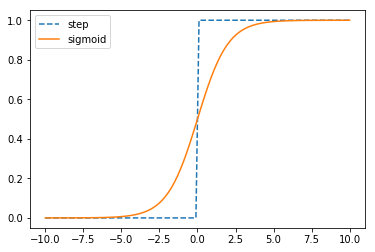

In [8]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

xs = np.linspace(-10,10,100)
ys = [step_function(x) for x in xs]
plt.plot(xs,ys,ls='--',label='step')
ys = [sigmoid(x) for x in xs]
plt.plot(xs,ys,ls='-',label='sigmoid')

plt.legend()

"Why use sigmoid instead of the simpler step_function ? In order to train a neural network, we’ll need to use calculus, and in order to use calculus, we need smooth functions. The step function isn’t even continuous, and sigmoid is a good smooth approximation of it."

- "Technically 'sigmoid' refers to the shape of the function, 'logistic' to this particular function although people often use the terms interchangeably."

In [10]:
def neuron_output(weights, inputs):
    return sigmoid(dot(weights, inputs))

"Given this function, we can represent a neuron simply as a list of weights whose length is one more than the number of inputs to that neuron (because of the bias weight). Then we can represent a neural network as a list of (noninput) layers, where each layer is just a list of the neurons in that layer."

- "*That is, we’ll represent a neural network as a list (layers) of lists (neurons) of lists (weights).*"

In [14]:
def dot(v, w):
    """
    v_1 * w_1 + ... + v_n * w_n
    """
    return sum(v_i * w_i 
               for v_i, w_i in zip(v, w))

def feed_forward(neural_network, input_vector):
    """
    takes in a neural network
    (represented as a list of lists of lists of weights)
    and returns the output from forward-propagating the input
    """
    outputs = []
    
    # process one layer at a time
    for layer in neural_network:
        input_with_bias = input_vector + [1] # add a bias input
        output = [neuron_output(neuron, input_with_bias) 
                  for neuron in layer] # compute the output for each neuron
        outputs.append(output) # and remember it

        # then the input to the next layer is the output of this one
        input_vector = output
    return outputs

"Now it’s easy to build the XOR gate that we couldn’t build with a single perceptron. We just need to scale the weights up so that the neuron_output s are either really close to 0 or really close to 1:"

In [15]:
xor_network = [# hidden layer
    [[20, 20, -30], # 'and' neuron
     [20, 20, -10]], # 'or' neuron
    # output layer
    [[-60, 60, -30]]] # '2nd input but not 1st input' neuron

for x in [0, 1]:
    for y in [0, 1]:
        # feed_forward produces the outputs of every neuron
        # feed_forward[-1] is the outputs of the output-layer neurons
        print(x, y, feed_forward(xor_network,[x, y])[-1])

0 0 [9.38314668300676e-14]
0 1 [0.9999999999999059]
1 0 [0.9999999999999059]
1 1 [9.383146683006828e-14]


"By using a hidden layer, we are able to feed the output of an 'and' neuron and the output of an 'or' neuron into a 'second input but not first input' neuron. The result is a network that performs 'or, but not and', which is precisely XOR".

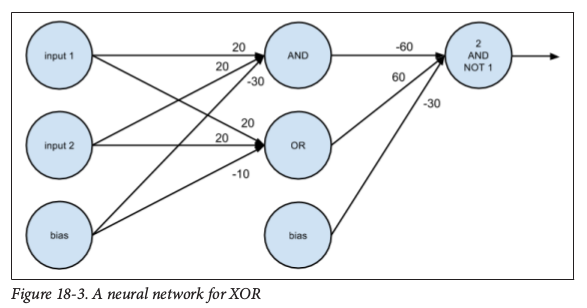

In [16]:
from IPython.display import Image
Image('xor-ann.png')

#### Backpropagation

"Imagine we have a training set that consists of input vectors and corresponding target output vectors. For example, in our previous xor_network example, the input vector \[1, 0\] corresponded to the target output \[1\]. And imagine that our network has some set of weights. We then adjust the weights using the following algorithm:

1. Run feed_forward on an input vector to produce the outputs of all the neurons in the network;
2. This results in an error for each output neuron—the difference between its output and its target;
3. Compute the gradient of this error as a function of the neuron’s weights, and adjust its weights in the direction that most decreases the error;
4. 'Propagate' these output errors backward to infer errors for the hidden layer;
5. Compute the gradients of these errors and adjust the hidden layer’s weights in the same manner."

In [17]:
def backpropagate(network, input_vector, targets):
    hidden_outputs, outputs = feed_forward(network, input_vector)

    # the output * (1 - output) is from the derivative of sigmoid
    output_deltas = [output * (1 - output) * (output - target) 
                     for output, target in zip(outputs, targets)]

    # adjust weights for output layer, one neuron at a time
    for i, output_neuron in enumerate(network[-1]):
        # focus on the ith output layer neuron
        for j, hidden_output in enumerate(hidden_outputs + [1]):
            # adjust the jth weight based on both
            # this neuron's delta and its jth input
            output_neuron[j] -= output_deltas[i] * hidden_output

    # back-propagate errors to hidden layer
    hidden_deltas = [hidden_output * (1 - hidden_output) * 
                     dot(output_deltas, [n[i] for n in output_layer])
                     for i, hidden_output in enumerate(hidden_outputs)]

    # adjust weights for hidden layer, one neuron at a time
    for i, hidden_neuron in enumerate(network[0]):
        for j, input_ in enumerate(input_vector + [1]):
            hidden_neuron[j] -= hidden_deltas[i] * input_

#### Example: Defeating CAPTCHA

~~~
zero_digit = [1,1,1,1,1,
              1,0,0,0,1,
              1,0,0,0,1,
              1,0,0,0,1,
              1,1,1,1,1]
~~~

~~~
# output for digit 4
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
~~~

In [23]:
inputs = [[1,1,1,1,1,
          1,0,0,0,1,
          1,0,0,0,1,
          1,0,0,0,1,
          1,1,1,1,1], # zero
         [0,0,1,0,0,
         0,0,1,0,0,
         0,0,1,0,0,
         0,0,1,0,0,
         0,0,1,0,0,], # one
         [1,1,1,1,1,
         0,0,0,0,1,
         1,1,1,1,1,
         1,0,0,0,0,
         1,1,1,1,1], #two
         [1,1,1,1,1,
         0,0,0,0,1,
         1,1,1,1,1,
         0,0,0,0,1,
         1,1,1,1,1], # three
         [1,0,0,0,1,
         1,0,0,0,1,
         1,1,1,1,1,
         0,0,0,0,1,
         0,0,0,0,1], # four
         [1,1,1,1,1,
         1,0,0,0,0,
         1,1,1,1,1,
         0,0,0,0,1,
         1,1,1,1,1], # five
         [1,1,1,1,1,
         0,0,0,0,1,
         1,1,1,1,1,
         1,0,0,0,1,
         1,1,1,1,1], # six
         [1,1,1,1,1,
         0,0,0,0,1,
         0,0,0,0,1,
         0,0,0,0,1,
         0,0,0,0,1], # seven
         [1,1,1,1,1,
         1,0,0,0,1,
         1,1,1,1,1,
         1,0,0,0,1,
         1,1,1,1,1], # eight
         [1,1,1,1,1,
         1,0,0,0,1,
         1,1,1,1,1,
         1,0,0,0,1,
         1,1,1,1,1] # nine
         ]

"assuming our inputs are correctly ordered from 0 to 9, our targets will be:"

In [18]:
targets = [[1 if i == j else 0 for i in range(10)] 
           for j in range(10)]

"so that (for example) targets\[4\] is the correct output for digit 4."

In [20]:
import random

random.seed(0) # to get repeatable results
input_size = 25 # each input is a vector of length 25
num_hidden = 5 # we'll have 5 neurons in the hidden layer
output_size = 10 # we need 10 outputs for each input

# each hidden neuron has one weight per input, plus a bias weight
hidden_layer = [[random.random() for _ in range(input_size + 1)] 
                for _ in range(num_hidden)]

# each output neuron has one weight per hidden neuron, plus a bias weight
output_layer = [[random.random() for _ in range(num_hidden + 1)]
                for _ in range(output_size)]

# the network starts out with random weights
network = [hidden_layer, output_layer]

In [24]:
# 10,000 iterations seems enough to converge
for __ in range(10000):
    for input_vector, target_vector in zip(inputs, targets):
        backpropagate(network, input_vector, target_vector)

In [25]:
def predict(input_):
    return feed_forward(network, input_)[-1]

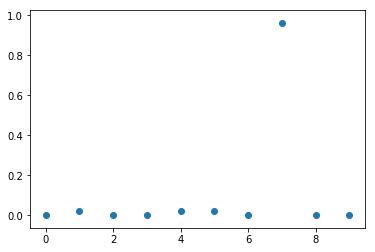

In [36]:
plt.scatter(range(10),predict(inputs[7]))

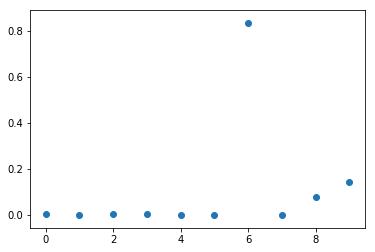

In [33]:
# stylized 3
p = predict([0,1,1,1,0,
         0,0,0,1,1,
         0,0,1,1,0,
         0,0,0,1,1,
         0,1,1,1,0])

plt.scatter(range(10),p)

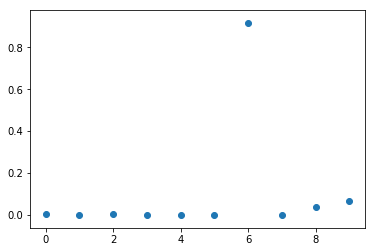

In [35]:
# stylized 8
p = predict([0,1,1,1,0,
             1,0,0,1,1,
             0,1,1,1,0,
             1,0,0,1,1,
             0,1,1,1,0])

plt.scatter(range(10),p)